Notebook to diagnose cluster information based on percentiles of e.g. rainfall, CWV, ...

James Ruppert  
jruppert@ou.edu  
10/17/24

### Main settings and read functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, colors
from precip_class import *
import seaborn as sns
import pickle
import pandas as pd
from scipy import stats
import cmocean

In [2]:
depend_var_tag = ['rainrate', 'PW']
nvar_ind = len(depend_var_tag)

storm = 'haiyan'
# storm = 'maria'

main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"+storm+'/'
datdir2 = 'post/d02/'
# main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'
main_pickle = "/Users/jamesruppert/code/tc_postproc/"+storm+'/'

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','STRATANVIL_ON','ncrf36h','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','CONVOFF','NCRF','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']
ntest=len(tests_str)

do_tests=False
if do_tests:
    nt_read=48
else:
    nt_read=85
    tests = ['ctl']
    tests_str = ['CTL']
    ntest=1

# Members
# nmem = 2
nmem = 10 # number of ensemble members (1-5 have NCRF)

#### Percentile settings

In [3]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# List containing percentile values
def get_percentiles():
    # Percentile array
    # nperc = 30
    # percentiles = np.logspace(-3, 2, num=nperc)
    # percentiles = np.array([1,2,3,4,5,6,7,8,9,
    #           10,20,30,40,50,60,70,80,90,
    #           100,200,300,400,500,600,700,800,900,
    #           1000,2000,3000,4000,5000,6000,7000,8000,9000,
    #           10000,20000,30000,40000,50000,60000,70000,80000,90000,])*1e-3
    percentiles = np.arange(2,100,2)
    return percentiles

#### Read processed variables

In [4]:
var_tag = ['rain', 'cwv', 'lwacre', 'sh', 'lh', 'vmf', 'condh']
nvar_depend = len(var_tag)

In [5]:
percentiles = get_percentiles()
nperc = percentiles.size

# Arrays to save variables
depend_var_perc = np.ma.zeros((nvar_ind, nperc))

dims = (nvar_ind, ntest, nmem, nt_read, nperc)
number = np.ma.zeros(dims)
mean_size = np.ma.zeros(dims)

dims = (nvar_depend, nvar_ind, ntest, nmem, nt_read, nperc)
var_all = np.ma.zeros(dims)

for ivar_ind in range(nvar_ind):

    # Get percentile values for independent variables
    pickle_file = main_pickle+memb_all[0]+'/percentile_cluster_'+depend_var_tag[ivar_ind]+'_'+tests[0]+'_'+str(nt_read)+'hrs.pkl'
    with open(pickle_file, 'rb') as file:
        idepend_var_perc, inumber, imean_size,irain_perc,icwv_perc,ilwacre_perc,ish_perc,ilh_perc,ivmf_perc,icondh_perc = pickle.load(file)
    depend_var_perc[ivar_ind,...] = idepend_var_perc

    for itest in range(ntest):
        test_str = tests[itest]
        # Loop over ensemble members
        for imemb in range(nmem):
            pickle_file = main_pickle+memb_all[imemb]+'/percentile_cluster_'+depend_var_tag[ivar_ind]+'_'+test_str+'_'+str(nt_read)+'hrs.pkl'
            with open(pickle_file, 'rb') as file:
                idepend_var_perc, inumber, imean_size, \
                    irain_perc,icwv_perc,ilwacre_perc,ish_perc,ilh_perc,ivmf_perc,icondh_perc \
                    = pickle.load(file)
            # Mask out sizes for values with number <= 1
            cond = (inumber <= 1)
            number[ivar_ind, itest, imemb,...]     = np.ma.masked_where(cond, inumber)
            mean_size[ivar_ind, itest, imemb,...]  = np.ma.masked_where(cond, imean_size)
            var_all[0, ivar_ind, itest, imemb,...] = np.ma.masked_where(cond, irain_perc) # mm/day
            var_all[1, ivar_ind, itest, imemb,...] = np.ma.masked_where(cond, icwv_perc) # mm
            var_all[2, ivar_ind, itest, imemb,...] = np.ma.masked_where(cond, ilwacre_perc) # W/m2
            var_all[3, ivar_ind, itest, imemb,...] = np.ma.masked_where(cond, ish_perc) # W/m2
            var_all[4, ivar_ind, itest, imemb,...] = np.ma.masked_where(cond, ilh_perc) # W/m2
            var_all[5, ivar_ind, itest, imemb,...] = np.ma.masked_where(cond, ivmf_perc) # kg/m/s
            var_all[6, ivar_ind, itest, imemb,...] = np.ma.masked_where(cond, icondh_perc) # W/m2

#### Percentiles based on size

In [6]:
# Mean diameter
area_grid_cell = 9 # km**2
diam = 2*np.sqrt((mean_size*area_grid_cell)/np.pi)

percentiles_isize = np.arange(5,100,5)
nperc_isize = percentiles_isize.size

# Arrays to save variables
sizes_perc = np.zeros((nvar_ind, nperc_isize))

dims = (nvar_ind, ntest, nmem, nt_read, nperc_isize)
number_isize = np.zeros(dims)

dims = (nvar_depend, nvar_ind, ntest, nmem, nt_read, nperc_isize)
var_all_isize = np.zeros(dims)

for ivar_ind in range(nvar_ind):
    sizes_perc[ivar_ind,:] = np.nanpercentile(diam[ivar_ind].flatten(), percentiles_isize)
    print()
    print(sizes_perc[ivar_ind,:])
    for itest in range(ntest):
        test_str = tests[itest]
        for imemb in range(nmem):
            for it in range(nt_read):
                isizes = diam[ivar_ind, itest, imemb, it, :]
                number_isize[ivar_ind, itest, imemb, it, :] = np.interp(sizes_perc[ivar_ind], isizes, number[ivar_ind, itest, imemb, it, :])
                for ivar_dep in range(nvar_depend):
                    var_all_isize[ivar_dep, ivar_ind, itest, imemb, it, :] = np.interp(sizes_perc[ivar_ind], isizes, var_all[ivar_dep, ivar_ind, itest, imemb, it, :])


[  2.           2.           2.           2.           2.
 159.68290939 169.71112443 176.41215886 182.31301068 187.74221471
 193.21875555 198.313806   204.0329762  210.61660473 219.0297871
 230.20146514 246.77241795 273.35070774 318.11580564]

[ 129.51906434  170.66542754  206.48798819  240.65967113  275.18716467
  309.9342551   345.50737328  382.63201124  422.79434407  464.53868268
  509.73326716  562.99657964  632.03174883  711.09414868  811.84027962
  927.74098008 1062.32256272 1263.24090327 1782.65071169]


/Users/jamesruppert/miniforge3/envs/plotting/lib/python3.12/site-packages/numpy/lib/_function_base_impl.py:4968: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


### Plotting

In [7]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

rc('font', **font)

sns.set_theme(style="darkgrid", rc={'xtick.bottom': True, 'ytick.left': True,})

In [8]:
x0_plot = np.zeros(nvar_ind)
for ivar_ind in range(nvar_ind):
    x0_plot[ivar_ind] = np.where(~number[ivar_ind,itest,0,20,:].mask)[0][0]

#### Histograms of N and mean size

In [9]:
def add_var(figdata, ax):
    ax.set_title(figdata['vartag'])
    ax.set_xlabel('Percentile')
    ax.set_ylabel(figdata['ylabel'])
    percentiles = figdata['percentiles']
    nmem, nt_read, nperc = figdata['pltvar'].shape
    data = (figdata['pltvar'].transpose((2,0,1))).reshape((nperc,nmem*nt_read))
    df = pd.DataFrame(data=data.transpose(), columns=percentiles)
    sns.boxplot(df, ax=ax, width=0.7, showmeans=True, showfliers=False,
                meanprops={"marker":"o", "markerfacecolor":"white",
                           "markeredgecolor":"black", "markersize":"6"})
    if 'x0' in figdata.keys():
        ax.set_xlim([figdata['x0'], nperc])
    if 'logscale' in figdata.keys():
        ax.set_yscale('log')
    return None

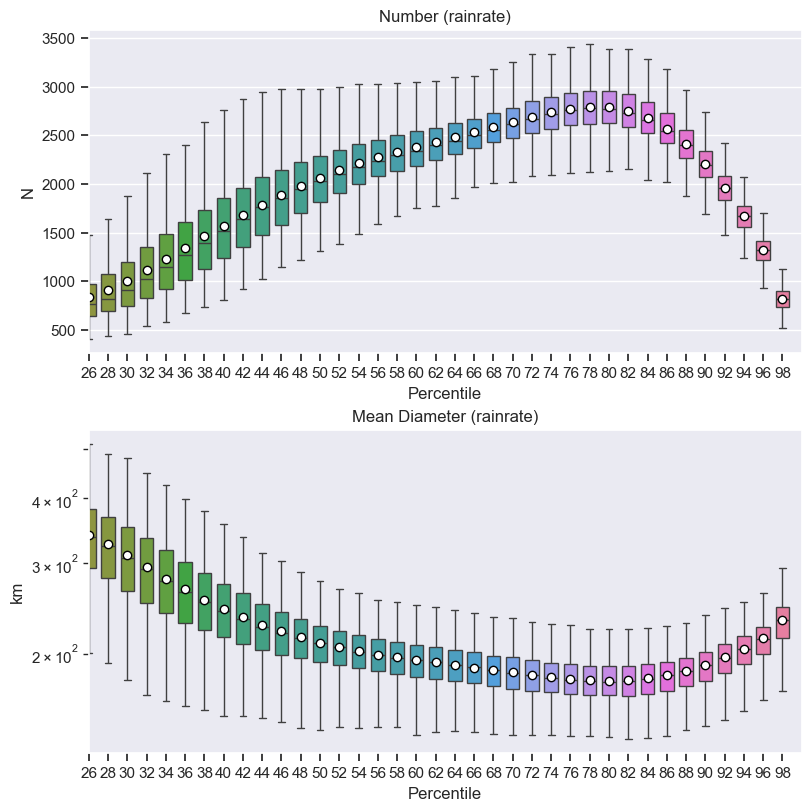

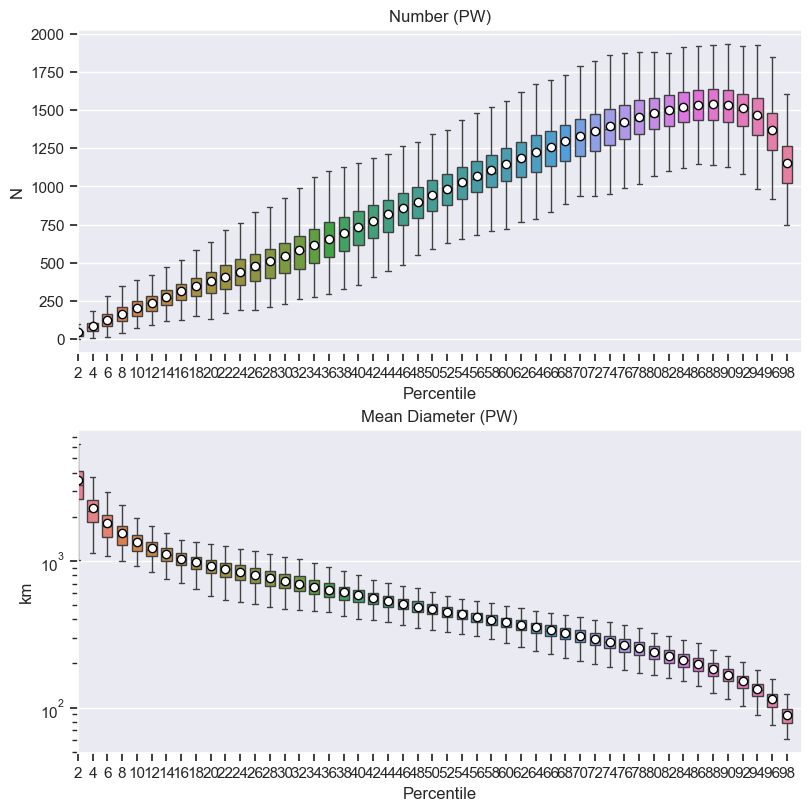

In [10]:
for ivar_ind in range(nvar_ind):

    fig_x = 8
    fig_y = 8
    fig, axs = plt.subplots(2,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

    for itest in range(ntest):

        figdata = {
            'pltvar': number[ivar_ind,itest,:,:,:],
            'vartag': 'Number ('+depend_var_tag[ivar_ind]+')',
            'ylabel': 'N',
            'percentiles': percentiles,
            'x0': x0_plot[ivar_ind],
            }

        add_var(figdata, axs[0])

        area_grid_cell = 9 # km**2
        diam = 2*np.sqrt((mean_size*area_grid_cell)/np.pi)

        figdata = {
            # 'pltvar': mean_size[ivar_ind,itest,:,:,:],
            'pltvar': diam[ivar_ind,itest,:,:,:],
            'vartag': 'Mean Diameter ('+depend_var_tag[ivar_ind]+')',
            'ylabel': 'km',
            'percentiles': percentiles,
            'x0': x0_plot[ivar_ind],
            'logscale': 1,
            }

        add_var(figdata, axs[1])

    plt.show()
    plt.close()

#### Main variables

In [11]:
vartag = ['Rain', 'PW', 'LW-ACRE', 'SH', 'LH', 'VMF', '$Q_c$', 'LW-ACRE/$LP$']
units = ['mm/d', 'mm', 'W/m$^2$', 'W/m$^2$', 'W/m$^2$', 'kg/m/s', 'W/m$^2$', '-']

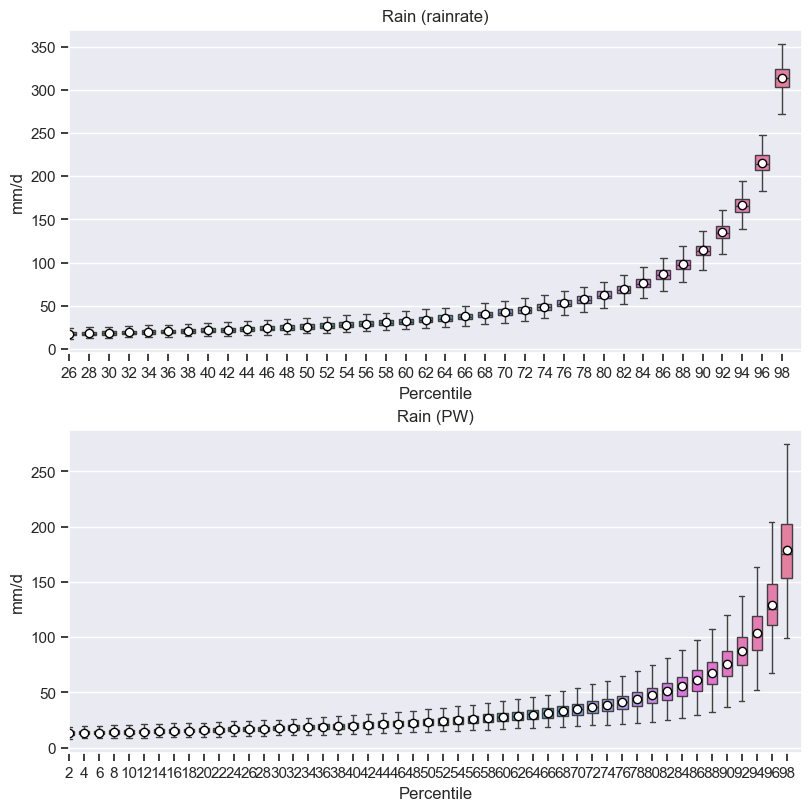

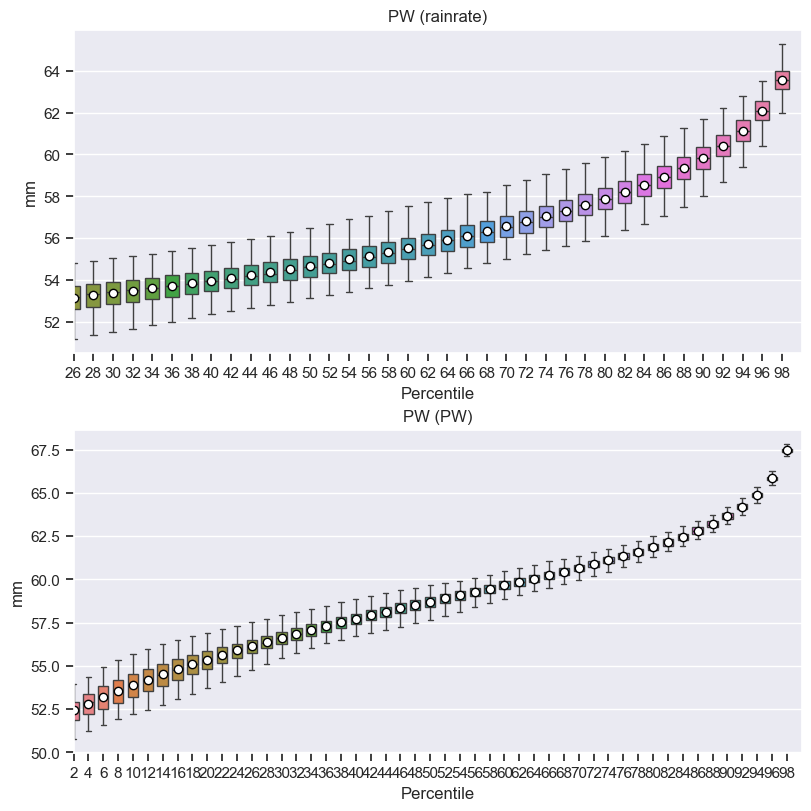

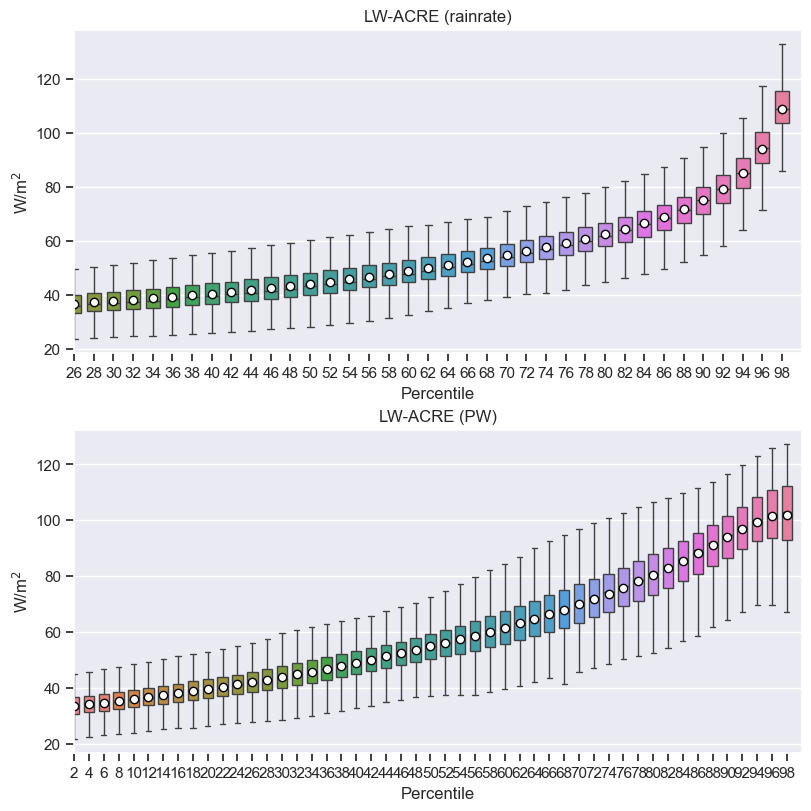

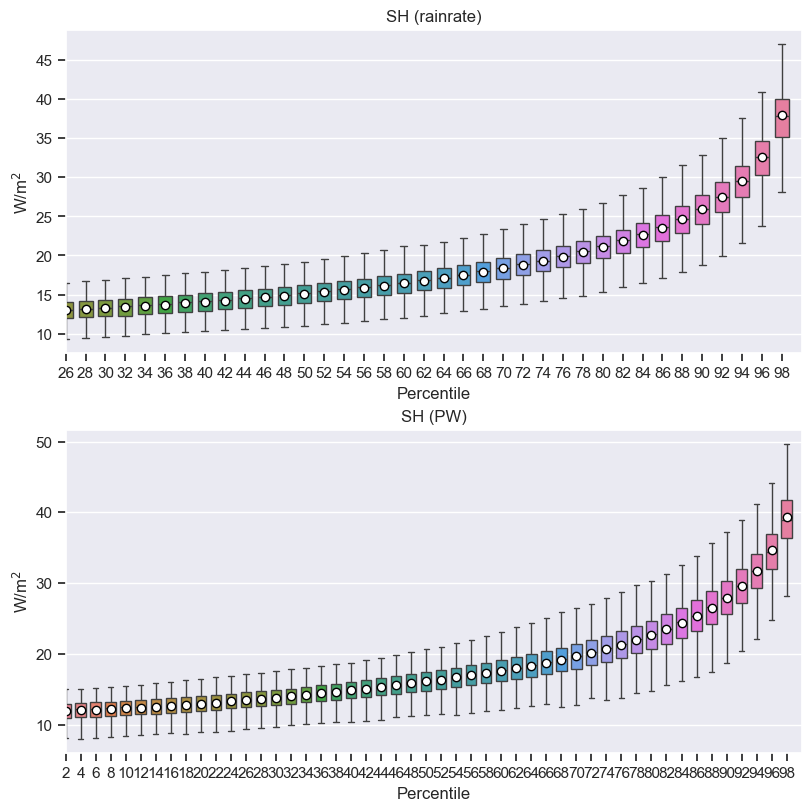

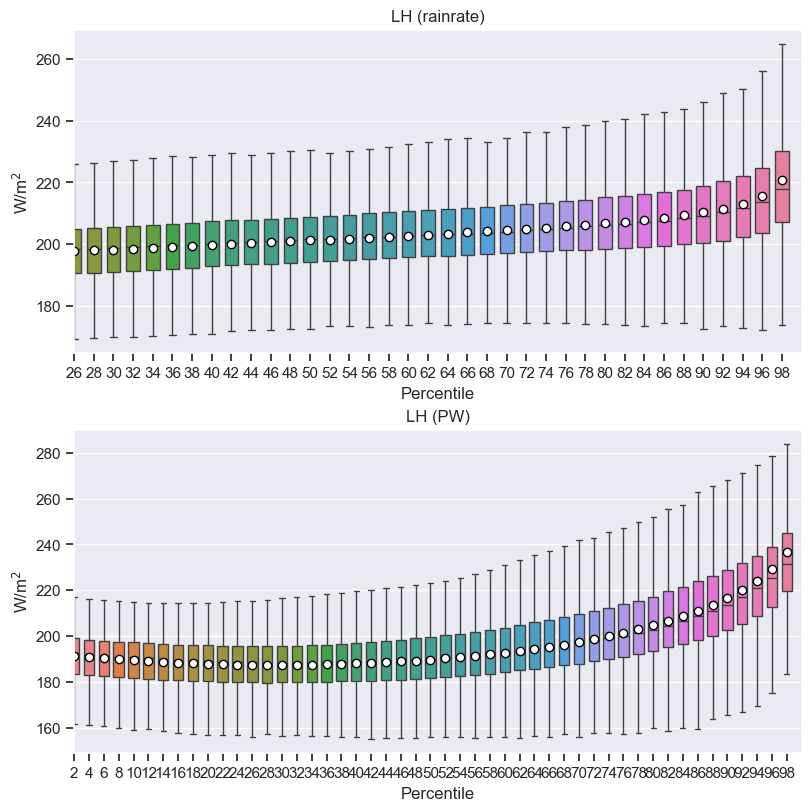

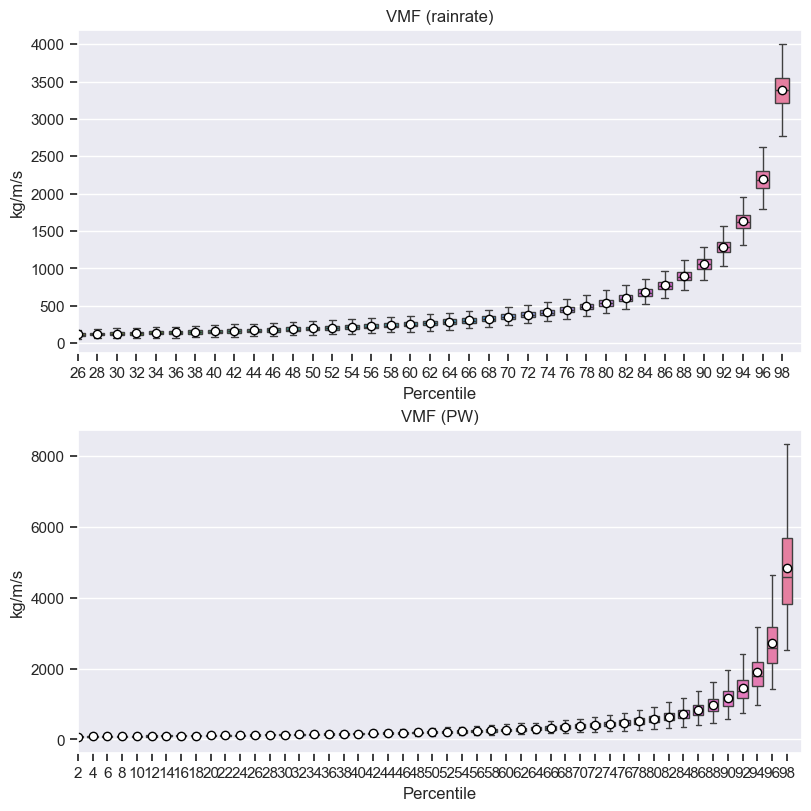

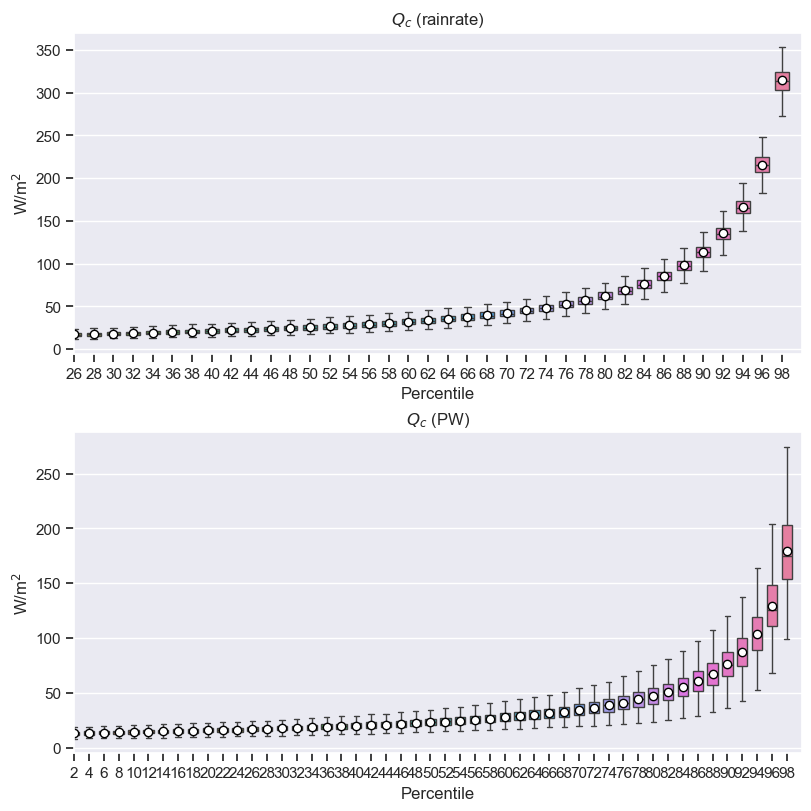

In [12]:
for ivar_dep in range(nvar_depend):

    fig_x = 8
    fig_y = 8
    fig, axs = plt.subplots(2,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

    for ivar_ind in range(nvar_ind):
        for itest in range(ntest):

            figdata = {
                'pltvar': var_all[ivar_dep,ivar_ind,itest,...],
                'vartag': vartag[ivar_dep]+' ('+depend_var_tag[ivar_ind]+')',
                'ylabel': units[ivar_dep],
                'percentiles': percentiles,
                # 'percentiles': depend_var_perc[ivar_ind,:],
                'x0': x0_plot[ivar_ind],
                # 'logscale': 1,
                }

            add_var(figdata, axs[ivar_ind])

    plt.show()
    plt.close()

#### Longwave enhancement factor

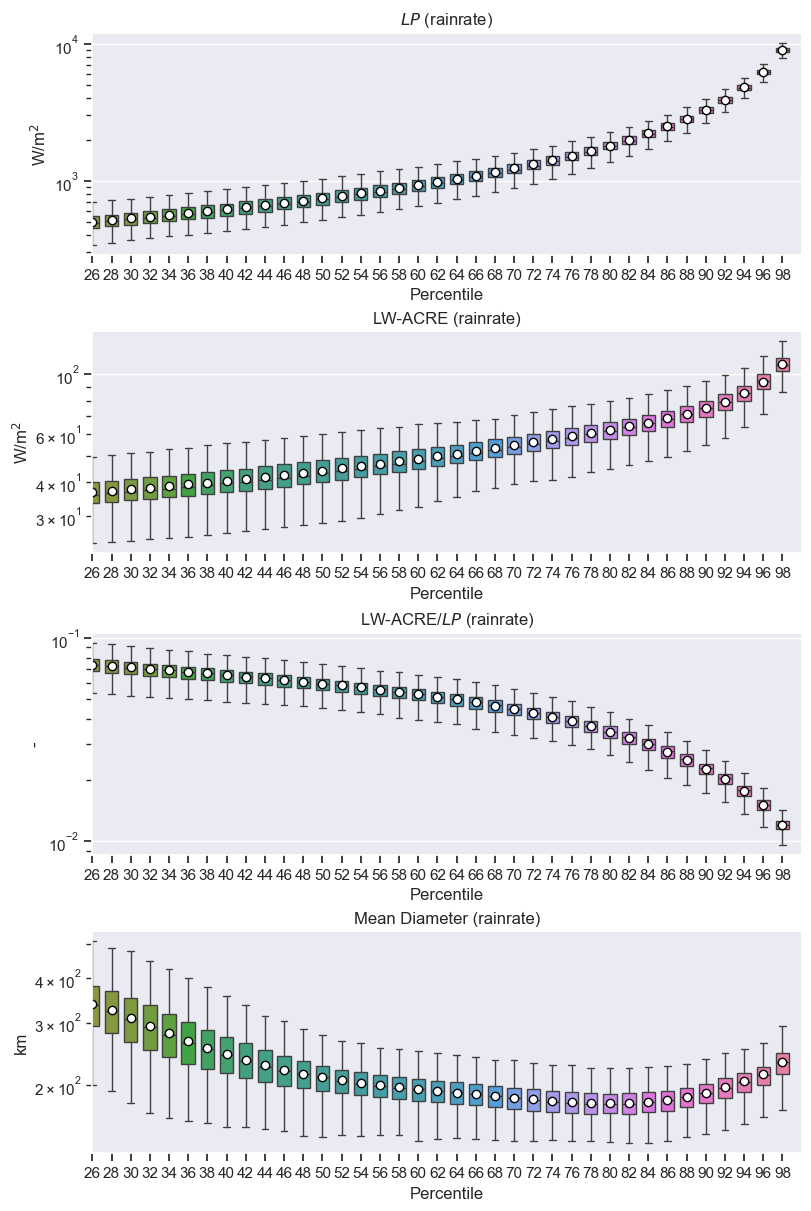

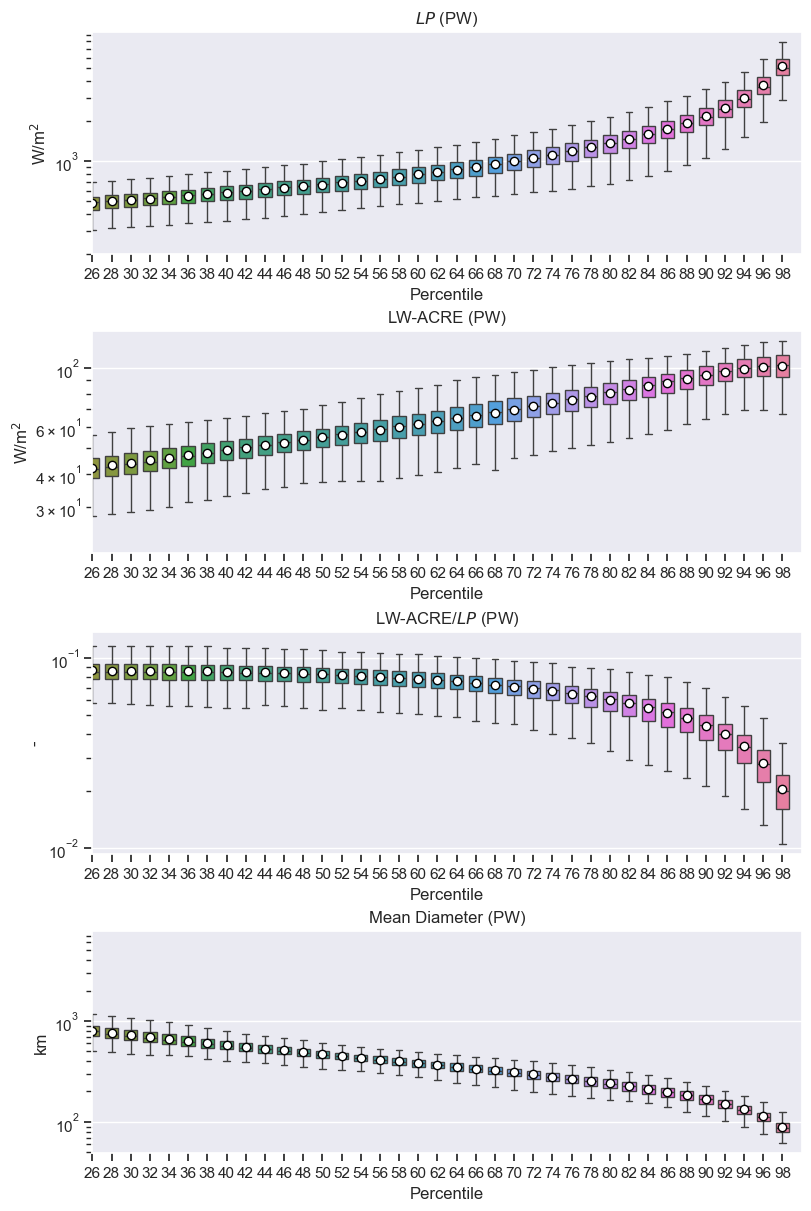

In [23]:
lv0 = 2.5e6 # J/kg
rain_wm2 = var_all[0]*lv0/(24*3600) # mm/d --> W/m2
lwfeedback = var_all[2] / rain_wm2

for ivar_ind in range(nvar_ind):
    for itest in range(ntest):

        fig_x = 8
        fig_y = 12
        fig, axs = plt.subplots(4,1, figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

        figdata = {
            'pltvar': rain_wm2[ivar_ind,itest,...],
            'vartag': '$LP$ ('+depend_var_tag[ivar_ind]+')',
            'ylabel': 'W/m$^2$',
            'percentiles': percentiles,
            # 'percentiles': depend_var_perc[ivar_ind,:],
            'x0': x0_plot[0],
            'logscale': 1,
            }

        add_var(figdata, axs[0])

        figdata['pltvar'] = var_all[2,ivar_ind,itest,...]
        figdata['vartag'] = 'LW-ACRE ('+depend_var_tag[ivar_ind]+')'

        add_var(figdata, axs[1])

        figdata['pltvar'] = lwfeedback[ivar_ind,itest,...]
        figdata['vartag'] = 'LW-ACRE/$LP$ ('+depend_var_tag[ivar_ind]+')'
        figdata['ylabel'] = '-'

        add_var(figdata, axs[2])

        figdata['pltvar'] = diam[ivar_ind,itest,...]
        figdata['vartag'] = 'Mean Diameter ('+depend_var_tag[ivar_ind]+')'
        figdata['ylabel'] = 'km'

        add_var(figdata, axs[3])

        plt.show()
        plt.close()

#### Size-dependent plots

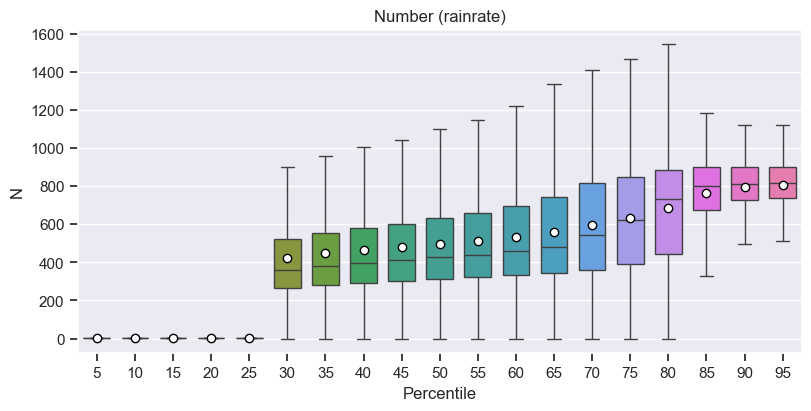

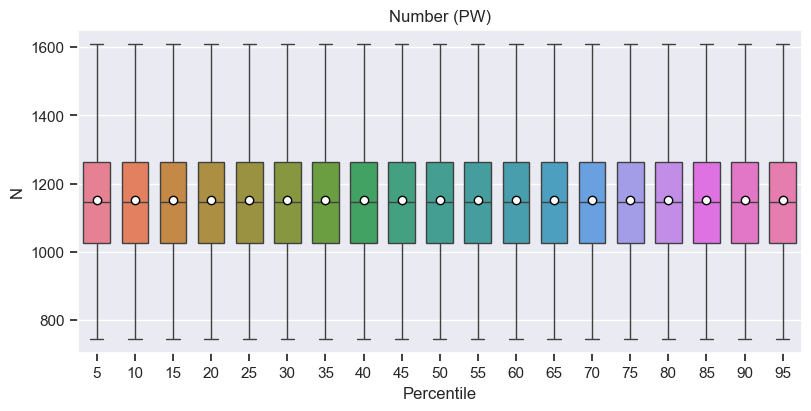

In [15]:
for ivar_ind in range(nvar_ind):

    fig_x = 8
    fig_y = 4
    fig, axs = plt.subplots(figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

    for itest in range(ntest):

        figdata = {
            'pltvar': number_isize[ivar_ind,itest,:,:,:],
            'vartag': 'Number ('+depend_var_tag[ivar_ind]+')',
            'ylabel': 'N',
            'percentiles': percentiles_isize,
            }

        add_var(figdata, axs)

    plt.show()
    plt.close()

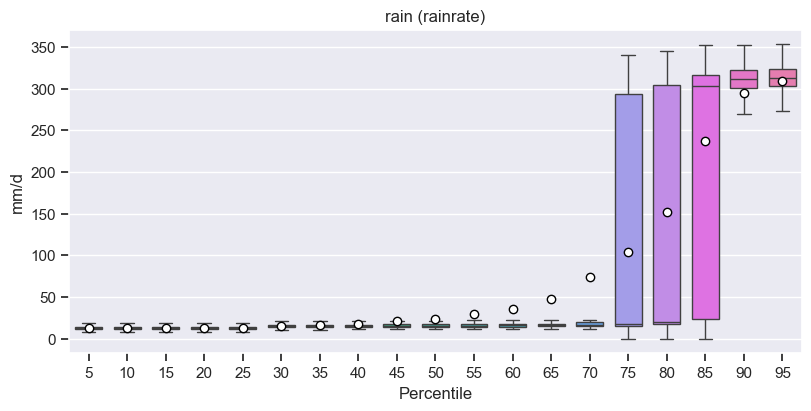

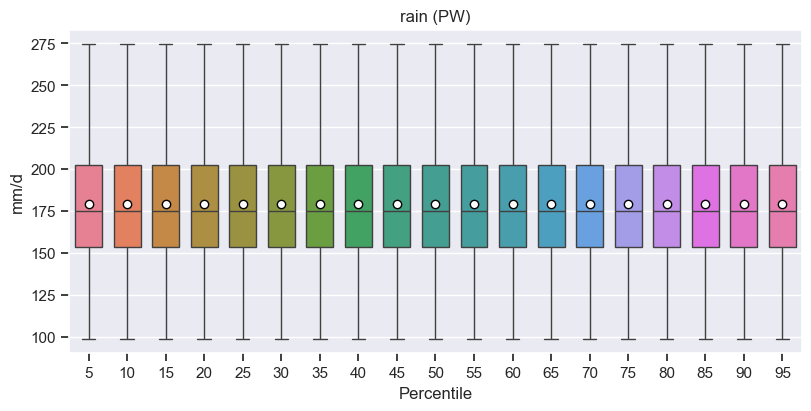

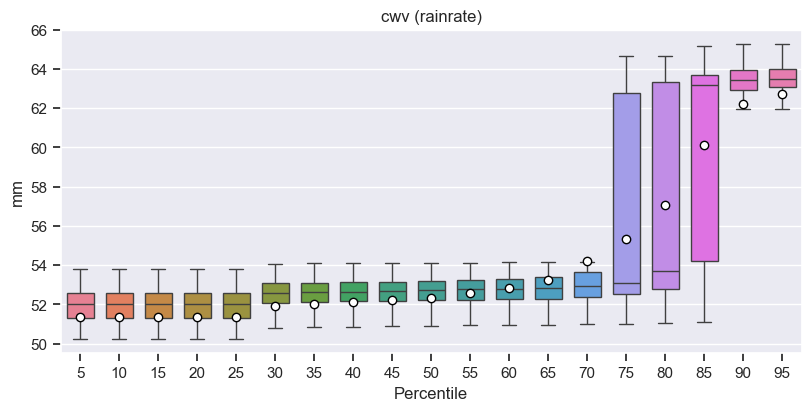

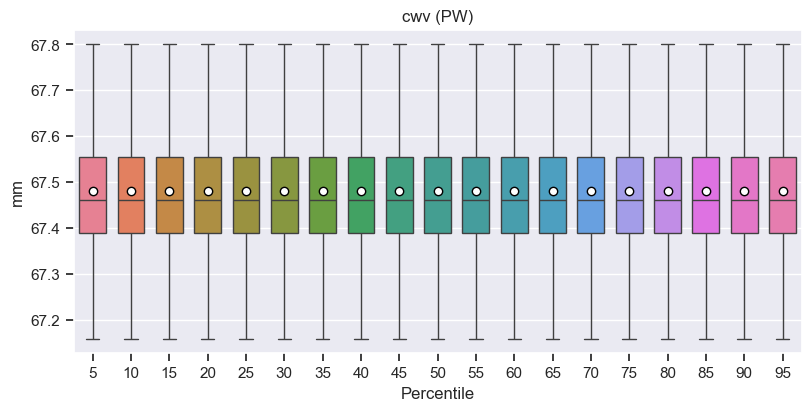

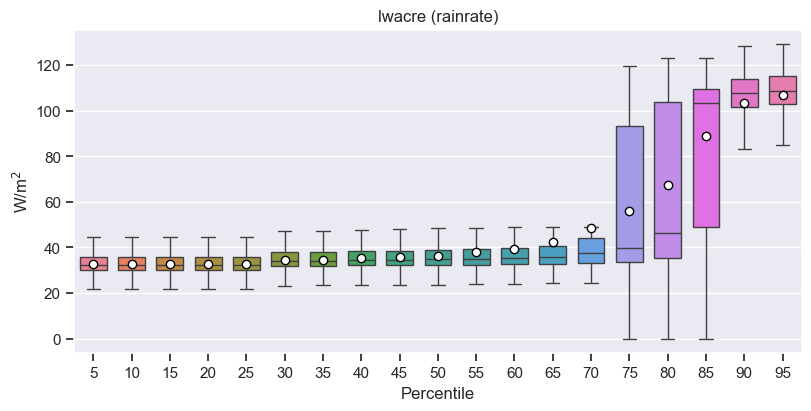

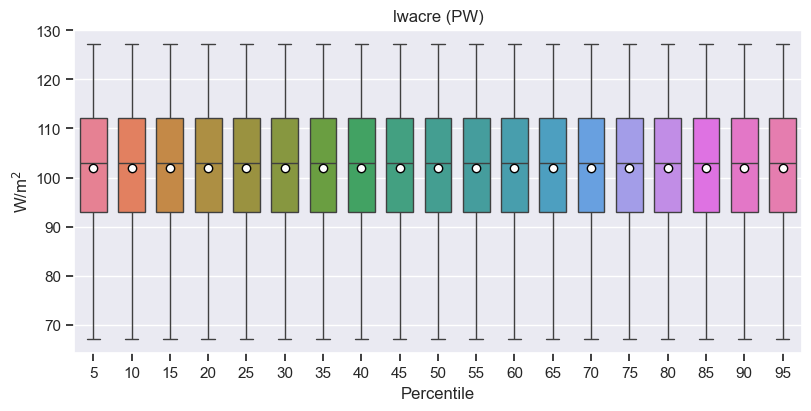

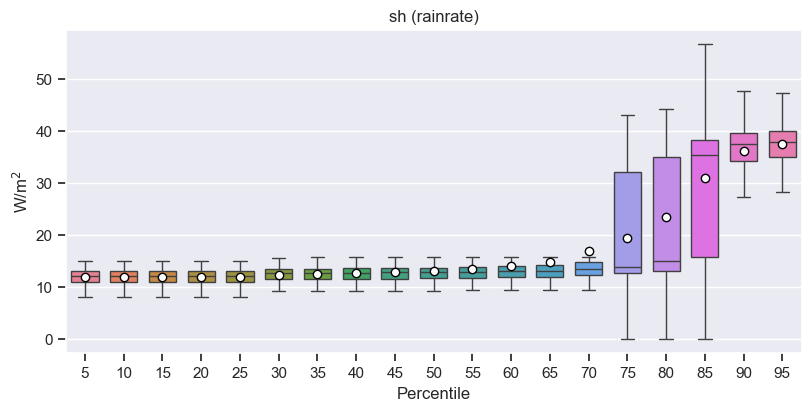

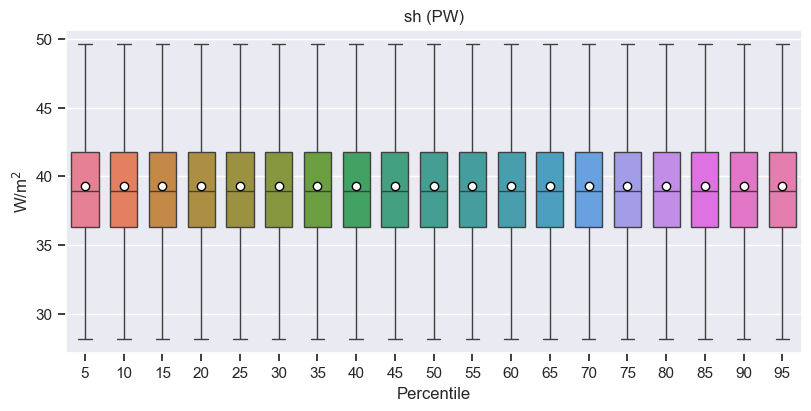

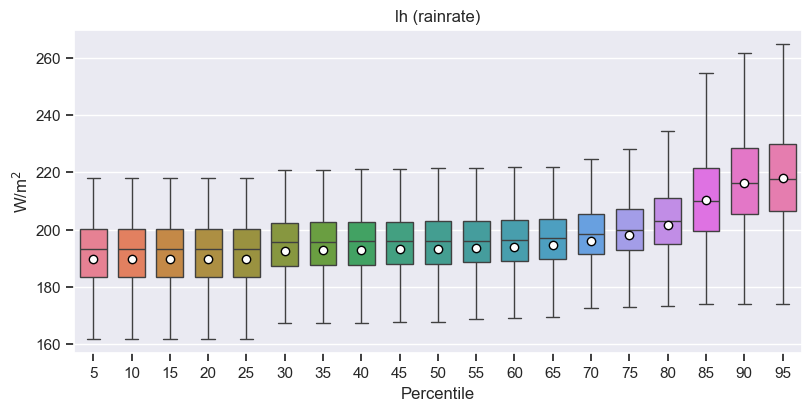

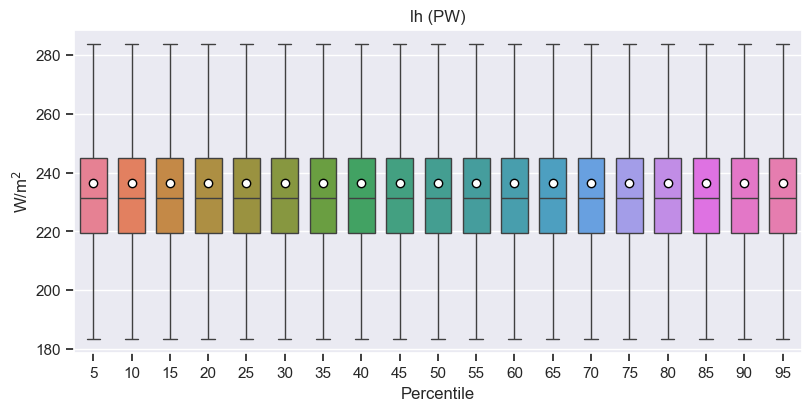

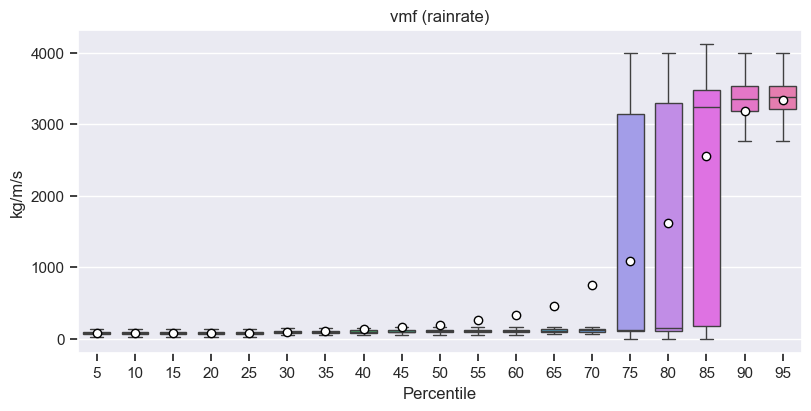

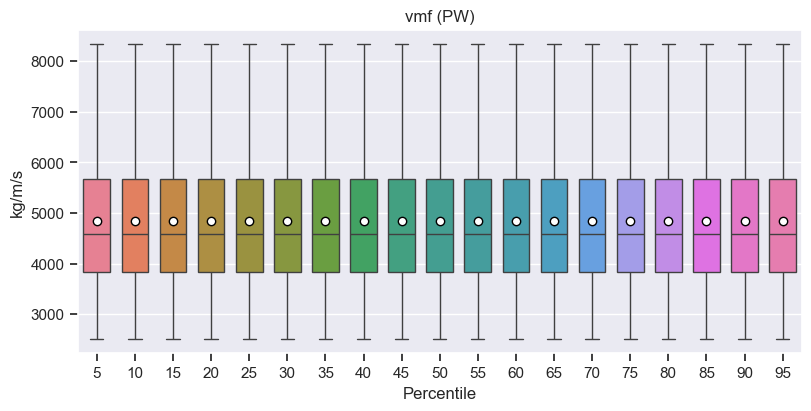

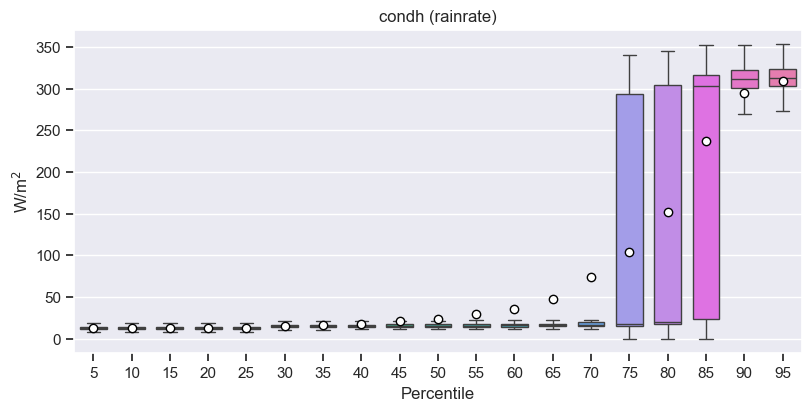

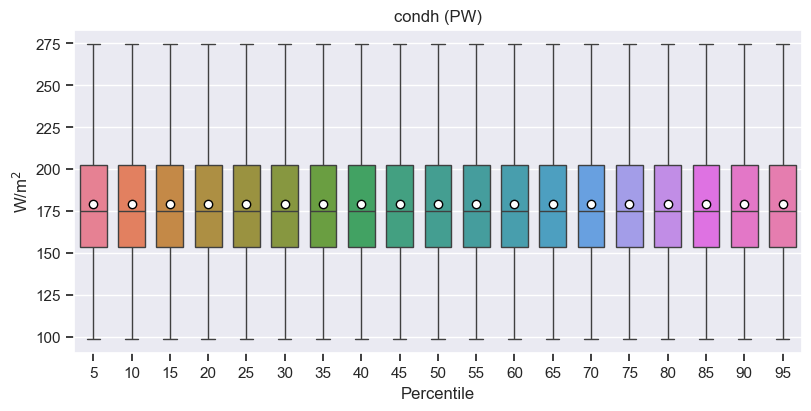

In [16]:
for ivar_dep in range(nvar_depend):
    for ivar_ind in range(nvar_ind):

        fig_x = 8
        fig_y = 4
        fig, axs = plt.subplots(figsize=(fig_x,fig_y), layout='constrained', squeeze=True)

        for itest in range(ntest):

            figdata = {
                'pltvar': var_all_isize[ivar_dep,ivar_ind,itest,:,:,:],
                'vartag': var_tag[ivar_dep]+' ('+depend_var_tag[ivar_ind]+')',
                'ylabel': units[ivar_dep],
                'percentiles': percentiles_isize,
                }

            add_var(figdata, axs)

        plt.show()
        plt.close()